In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
# from efficientnet_pytorch import EfficientNet
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
from PIL import Image, ImageDraw
from tqdm import tqdm

In [67]:
train_sample_metadata = pd.read_json('./input/dfdc_train_part_0/metadata.json').T
train_sample_metadata.head()
train_sample_metadata.info()
train_sample_metadata.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1334 entries, owxbbpjpch.mp4 to etychryvty.mp4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     1334 non-null   object
 1   split     1334 non-null   object
 2   original  1248 non-null   object
dtypes: object(3)
memory usage: 74.0+ KB


,label,split,original
count,1334,1334,1248
unique,2,1,86
top,FAKE,train,fdpisghkmd.mp4
freq,1248,1334,36


In [4]:
input_dir = './output/deepfake-detection-challenge/dfdc_train_part_0/'
real_dirs = []
fake_dirs = []
for i in range(len(train_sample_metadata)):
    fn = train_sample_metadata.index[i]
    label = train_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, real_dirs, fake_dirs, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform
        
        for directory in real_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(0)
                    
        for directory in fake_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(1)
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert('RGB')
        image = image.resize((224, 224))
        label = self.label_list[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dataset = CustomDataset(real_dirs, fake_dirs, transform=train_transforms)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_dataset, test_size=0.2)

In [8]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# model = EfficientNet.from_pretrained('efficientnet-b0')
# Using Swish
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Stem
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.swish1 = nn.SiLU()
        # Blocks
        self.blocks = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.SiLU(),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.SiLU(),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.SiLU(),
            ),
        )
        # Head
        self.conv2 = nn.Conv2d(32, 128, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.swish2 = nn.SiLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.swish1(x)
        # Blocks
        x = self.blocks(x)
        # Head
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.swish2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MyModel()

In [11]:
def display_model(model):
    # Check number of parameters 
    summary_dict = {}
    num_params = 0
    summary_str = ['='*80]

    for module_name, module in model.named_children():
        summary_count = 0
        for name, param in module.named_parameters():
            if(param.requires_grad):
                summary_count += param.numel()
                num_params += param.numel()
        summary_dict[module_name] = [summary_count]
        summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

    summary_dict['total'] = [num_params]

    # print summary string
    summary_str += ['='*80]
    summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
    print('\n'.join(summary_str))

    # print model structure
    print(model)

In [12]:
# model._fc = torch.nn.Linear(1280, 1)

In [13]:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model._fc.parameters():
#     param.requires_grad = True

In [14]:
display_model(model)
# model.compile(loss="binary_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.summary()

- conv1                                    :                864                
- bn1                                      :                 64                
- swish1                                   :                 0                 
- blocks                                   :               82560               
- conv2                                    :                4096               
- bn2                                      :                256                
- swish2                                   :                 0                 
- pool                                     :                 0                 
- fc                                       :                129                
--Total                                    :            87969 params           --
MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (swish1): 

In [16]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        with torch.no_grad():
            output = model(images)
            preds = torch.round(torch.sigmoid(output)).type(torch.int)
            loss = criterion(output, labels)
            losses.append(loss.item())
            correct += (preds == labels).sum().item()
            total += len(labels)
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

In [17]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [18]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.258: 100%|██████████| 580/580 [00:40<00:00, 14.41it/s]


Loss for Training on epoch 0 is 0.2880215346813202 

Evaluating Network


Validating ...: 100%|██████████| 580/580 [00:20<00:00, 27.87it/s]


Mean Accuracy: 0.9172
Avg loss: 0.27940719633780675
Training accuracy on epoch 0 is 0.9171655071994823 



Validating ...: 100%|██████████| 145/145 [00:08<00:00, 17.59it/s]

Training ...:  20%|██        | 1/5 [01:09<04:37, 69.42s/it]

Mean Accuracy: 0.9280
Avg loss: 0.2609849093803044
Testing accuracy on epoch 0 is 0.9279551337359793 



loss: 0.415: 100%|██████████| 580/580 [00:38<00:00, 14.94it/s]


Loss for Training on epoch 1 is 0.2652791440486908 

Evaluating Network


Validating ...: 100%|██████████| 580/580 [00:19<00:00, 30.47it/s]


Mean Accuracy: 0.9173
Avg loss: 0.26430279246435084
Training accuracy on epoch 1 is 0.9172733646119829 



Validating ...: 100%|██████████| 145/145 [00:37<00:00,  3.91it/s]

Training ...:  40%|████      | 2/5 [02:44<04:13, 84.52s/it]

Mean Accuracy: 0.9280
Avg loss: 0.24847816223728245
Testing accuracy on epoch 1 is 0.9279551337359793 



loss: 0.501: 100%|██████████| 580/580 [00:45<00:00, 12.89it/s]

Training ...:  60%|██████    | 3/5 [03:29<02:13, 66.50s/it]

Loss for Training on epoch 2 is 0.2635115087032318 



loss: 0.104: 100%|██████████| 580/580 [00:44<00:00, 12.89it/s]

Training ...:  80%|████████  | 4/5 [04:14<00:58, 58.03s/it]

Loss for Training on epoch 3 is 0.261189728975296 



loss: 0.326: 100%|██████████| 580/580 [00:39<00:00, 14.53it/s]


Loss for Training on epoch 4 is 0.2596949338912964 

Evaluating Network


Validating ...: 100%|██████████| 580/580 [00:21<00:00, 27.58it/s]


Mean Accuracy: 0.9174
Avg loss: 0.44081184657386924
Training accuracy on epoch 4 is 0.9173812220244836 



Validating ...: 100%|██████████| 145/145 [00:24<00:00,  5.94it/s]

Training ...: 100%|██████████| 5/5 [05:40<00:00, 68.02s/it]

Mean Accuracy: 0.9282
Avg loss: 0.39897437248828593
Testing accuracy on epoch 4 is 0.9281708369283865 



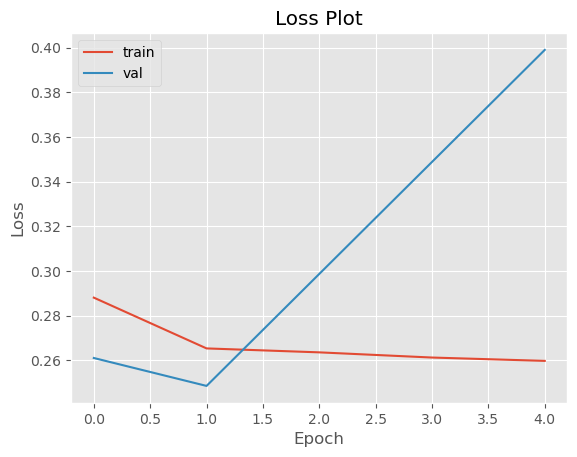

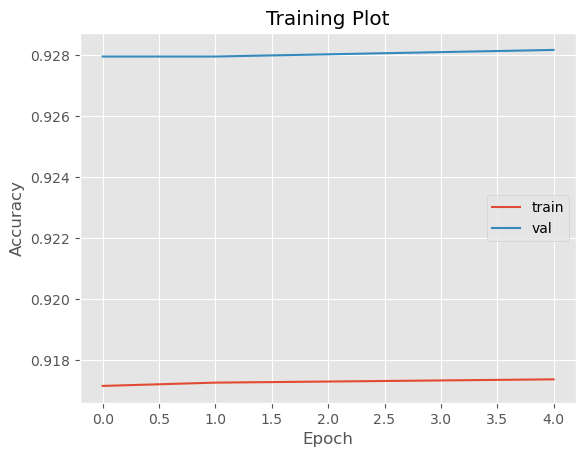

In [19]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

In [58]:
import random
def eval_example(model, dirs):
    model.eval()
    image_path = random.choice(dirs)+'0.jpg'
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    image = image.resize((224, 224))
    image = train_transforms(image).unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    print(output.item())
    if pred>0.5:
        print('Prediction: FAKE')
    else:
        print('Prediction: REAL')

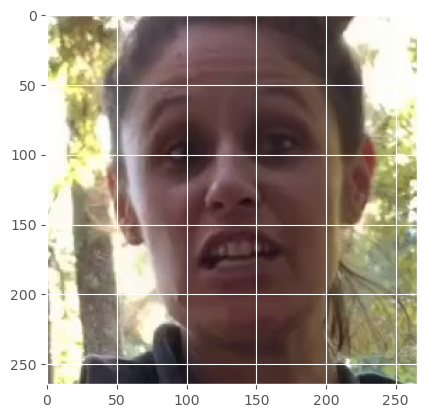

3.3157167434692383
Prediction: FAKE


In [64]:
f = eval_example(model, fake_dirs)

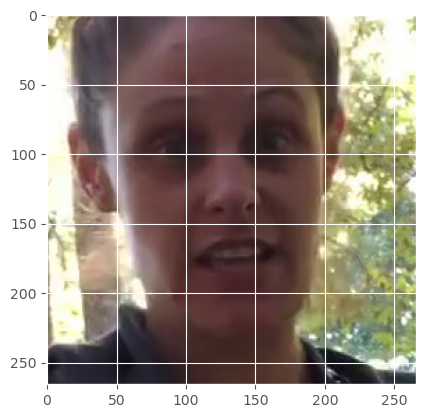

3.9168858528137207
Prediction: FAKE


In [62]:
r = eval_example(model, real_dirs)

86


1248
